<a href="https://colab.research.google.com/github/pcummer/deep_learning_short_projects/blob/main/model_assisted_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is intended as a quick and practical guide to streamlining the data exploration stage of the standard data science workflow. 

Datasets in industry are rarely the product of a serious annotation project with multiple rounds of data cleaning and revision to the schema, but rather arise out of what is available or can be cheaply crowdsourced. Understanding and navigating the intracacies of such a dataset is crucial to successful modeling and can easily consume the majority of the time spent working on the problem when datasets comprise tens of thousands of examples. 

My suggested approach is to harness the power of a preliminary model trained on the dataset to more effectively target the search for anomalies and interesting slices of the data. A standard, modern architecture, pretrained on ImageNet or similar, can achieve the necessary performance with minimal tweaking of the training regime. While the model is of course focused on learning the target classes, it is in fact learning far more including partitioning sub-classes, identifying hard examples, and incorrect annotations.

For the purposes of this guide, I will work with the familiar Kaggle Dogs and Cats Dataset since it is easily available. As is, it is relatively clean, but we can intentionally corrupt it with different types of noise to simulate a more difficult industry dataset.

A Note on Reproducibility: I haven't yet fixed all the random seeds in this notebook, so feel free to step through the code, but expect the results to change and the associated commentary to be less relevant.

In [ ]:
!pip install albumentations # https://arxiv.org/abs/1809.06839
!pip install efficientnet # https://arxiv.org/abs/1905.11946

     |████████████████████████████████| 634kB 6.0MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=ad258ef7f99658efd9b44ffa0587fc858832ea1559e1dfa9374843e4e38f2712
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

image_directory = 'PetImages/'

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/5523.jpg  

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np

# Create a dataframe mapping filename to label
df_cat = pd.DataFrame(['Cat/' + x for x in os.listdir('PetImages/Cat/')])
df_dog = pd.DataFrame(['Dog/' + x for x in os.listdir('PetImages/Dog/')])

df_cat.columns = ['filename']
df_dog.columns = ['filename']

df_cat['label'] = 0
df_dog['label'] = 1

df = df_cat.append(df_dog)
df.reset_index(inplace=True, drop=True)

# Decimate the dataset to reduce runtime of the rest of this notebook, use a fixed seed for reproducibility
np.random.seed(0)
df = df.sample(frac=0.1, random_state=0)

# Clean out images that won't load with opencv
for path in df.filename:
  img = cv2.imread('PetImages/' + path)
  if img is None:
    df = df[df.filename != path]

# Split data into train, val, and test sets; if we were more concerned about training a high performing model, we might decide to stratify the split so the class balance is consistent
df_train = df.sample(frac=0.7)
df_val = df[~df.index.isin(df_train.index)]
df_test = df_val.sample(frac=0.5)
df_val = df_val[~df_val.index.isin(df_test.index)]

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations
import cv2

def geometric_aug(p=1.0):
    return albumentations.Compose([
        albumentations.RandomRotate90(p=0.5),
        albumentations.Flip(p=0.5)
    ])


class customImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, directory, batch_size, augmentation_strategy, color_balance=True, shuffle=True):
        self.df = df
        self.directory = directory
        self.batch_size = batch_size
        self.augmentation_strategy = augmentation_strategy
        self.color_balance = color_balance
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1.0)

    def __getitem__(self, index):
        indexes = np.arange(index * self.batch_size, (index + 1) * self.batch_size)
        batch_input = []
        batch_target = []
        for i in indexes:
            img = self.load_img(self.df.filename.iloc[i])
            label = self.df.label.iloc[i]
            batch_input.append(img)
            batch_target.append(label)

        batch_input = np.stack(batch_input)
        batch_target = np.array(batch_target)

        return batch_input, batch_target

    def load_img(self, filename):
        img = cv2.imread(self.directory + filename)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        if self.color_balance:
            img = simplestCB(img)
        img = self.augmentation_strategy(image=img)['image']
        img = img / 255.0
        return img


def simplestCB(img, percent=1.0):
    img = img.copy()
    for i in range(0, img.shape[2]):
        values = img[:,:,i].flatten()
        low = np.percentile(values, percent)
        high = np.percentile(values, 100 - percent)
        img[img[:, :, i] > high, i] = high
        img[img[:, :, i] < low, i] = low
        img[:, :, i] = (255 * (img[:, :, i].astype(np.float32) - low) / (high - low + 1E-10)).astype(np.uint8)
    return img


In [ ]:
# Instantiate generators that will take care of loading and augmenting the images for training
train_generator = customImageGenerator(df_train, image_directory, 64, geometric_aug(1.0))
val_generator = customImageGenerator(df_val, image_directory, 64, geometric_aug(0.0))
test_generator = customImageGenerator(df_train, image_directory, 64, geometric_aug(0.0))

In [ ]:
import efficientnet.tfkeras as efn

# Create a model pretrained on imagenet
model_input = tf.keras.layers.Input((224, 224, 3))
model_body = efn.EfficientNetB0(include_top=False)(model_input)
model_pooling = tf.keras.layers.GlobalAveragePooling2D()(model_body)
model_output = tf.keras.layers.Dense(1, activation='sigmoid')(model_pooling)

model = tf.keras.models.Model(inputs=model_input, outputs=model_output)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-4), loss='binary_crossentropy', metrics=['acc'])

16809984/16804768 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, None, None, 1280)  4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# Train the model, this retains some stochasticity despite fixing the random seed on the data decimation
model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
27/27 [==============================] - 23s 836ms/step - loss: 0.4360 - acc: 0.8380 - val_loss: 0.2479 - val_acc: 0.8969
Epoch 2/5
27/27 [==============================] - 21s 786ms/step - loss: 0.1867 - acc: 0.9392 - val_loss: 0.2783 - val_acc: 0.8719
Epoch 3/5
27/27 [==============================] - 21s 790ms/step - loss: 0.1024 - acc: 0.9757 - val_loss: 0.2115 - val_acc: 0.8969
Epoch 4/5
27/27 [==============================] - 21s 794ms/step - loss: 0.0785 - acc: 0.9711 - val_loss: 0.2221 - val_acc: 0.9094
Epoch 5/5
27/27 [==============================] - 21s 792ms/step - loss: 0.0586 - acc: 0.9838 - val_loss: 0.1515 - val_acc: 0.9312


We now have a preliminary model with strong performance on this dataset.

In [ ]:
# Drop the dense layer of the model to instead output the model's internal representation of the example
model_latent_output = tf.keras.models.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
model_latent_output.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, None, None, 1280)  4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 4,049,564
Trainable params: 4,007,548
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# Currently a bit slow since it is not batched
df['embedding'] = None
for path in df.filename:
  img = cv2.imread(image_directory + path)
  img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
  img = simplestCB(img)
  img = img / 255.0
  latent_representation = np.squeeze(model_latent_output.predict(np.expand_dims(img, axis=0)))
  df.embedding.loc[df.filename == path] = [latent_representation]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Reducing dimensionality of latent space for visualization, PCA down to 50 dimensions first for performance
tsne = TSNE(2)
pca = PCA(50)

output = tsne.fit_transform(pca.fit_transform(np.stack([np.array(x) for x in df.embedding])))

df['tsne_x'] = output[:,0]
df['tsne_y'] = output[:,1]

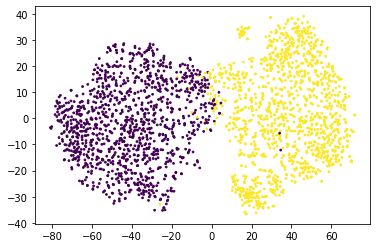

In [ ]:
import matplotlib.pyplot as plt

# Plot the latent representations and color by the ground truth label, purple is cat, yellow is dog
plt.scatter(df.tsne_x, df.tsne_y, c=df.label,s=3)

As expected from the high validation accuracy, we see very clear separation in the latent space between images of cats and images of dogs. There are three features that immediately stand out: the small yellow island around (x=20, y=35), the two cat images mixed into the dog images around (x=40, y=-10), and the area of overlap between the distributions around (x=0, y=10).

We'll now explore each of those in order.

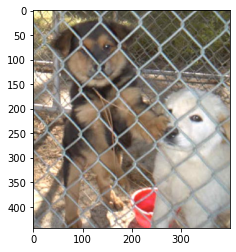

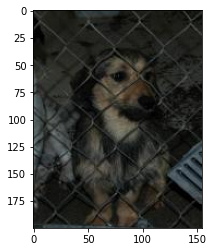

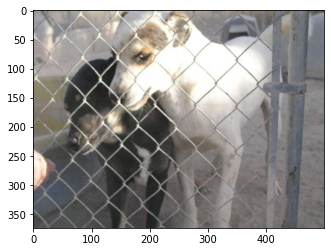

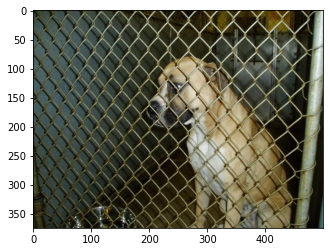

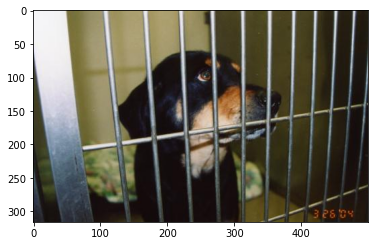

In [ ]:
# Show examples from the yellow island
for path in df[(df.tsne_x < 25) & (df.tsne_y > 30) & (df.label==1)].filename.sample(5):
  img = cv2.imread(image_directory + path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()

An island in the latent space of a model usually indicates a particularly distinctive sub-class or a strong visual artifact. In this case, we see that we have something between the two. This island corresponds to images of dogs in cages or behind fences giving a very strong visual differentiator.

We could automatically assign of label of 'Fence/Cage' to any image that lands in this cluster without needing to pay for any additional annotation. This highlights the key premise of this exercise: **the model's internal representation is far richer than the annotation.** (This may seem counterintuitive, but remember that the representation fuses information from the annotation with information from the image, and potentially information from the pre-training.)


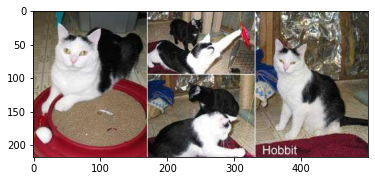

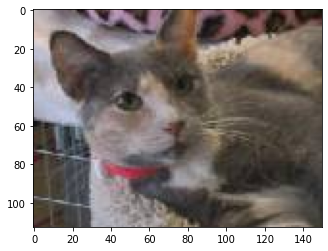

In [ ]:
# Show cat examples deep in dog territory
for path in df[(df.tsne_x > 20) & (df.label==0)].filename:
  img = cv2.imread(image_directory + path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()

We see two separate issues at play here. The first image is in fact of composite of images and is likely therefore causing confusion. The second appears to just be genuine model error, perhaps driven by the relatively poor image quality.

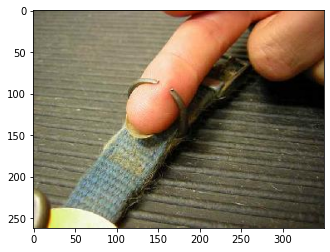

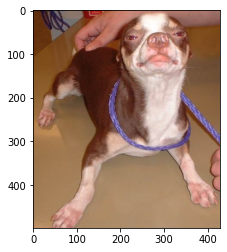

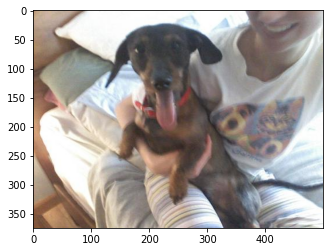

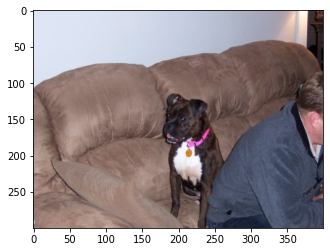

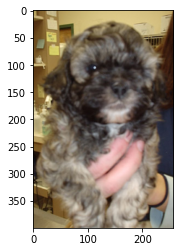

In [ ]:
# Show dogs from the high confusion area
for path in df[(df.tsne_x < 5) & (df.tsne_x > -5) & (df.tsne_y > 5) & (df.tsne_y < 15) & (df.label==1)].filename.sample(5):
  img = cv2.imread(image_directory + path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()

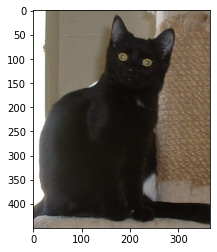

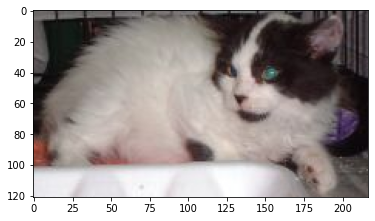

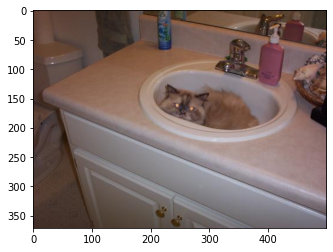

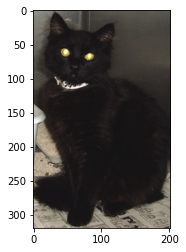

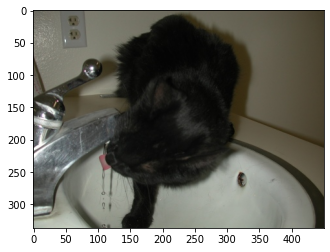

In [ ]:
# Show cats from the high confusion area
for path in df[(df.tsne_x < 5) & (df.tsne_x > -5) & (df.tsne_y > 5) & (df.tsne_y < 15) & (df.label==0)].filename.sample(5):
  img = cv2.imread(image_directory + path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()

Here we see our first example of open-set noise with the picture of the human hand labeled as a dog (see https://openaccess.thecvf.com/content_cvpr_2018/papers/Wang_Iterative_Learning_With_CVPR_2018_paper.pdf for a good overview of open-set noise). This raises a flag to investigate further and remove such examples, but we'll put that aside as this guide is scoped to identifying rather than remediating issues. (My recommended next step is a more exhaustive review of images from this area of the latent space.)

The other examples are clearly difficult but not problematic bringing us to another key point: **difficult examples and noisy examples are very difficult to distinguish.** To maximize model performance, we need accurately annotated examples along the class boundary such as these. 

A typical human-in-the-loop training approach might focus on labeling examples where the model output probability is near 1/2 i.e. the decision is borderline. I propose a slightly modified approach: annotating examples from the high confusion portion of the latent space. Since we have reserved 90% of our data, this is a testable hypothesis.

To be continued...